<a href="https://colab.research.google.com/github/lustea0201/Biomedical-Data-Science/blob/master/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the training dataset


In [108]:
!rm -rf data.zip


import zipfile

from google.colab import drive
drive.mount('/content/drive/')

data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r')

data.extractall()
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os 
from torchvision.datasets import ImageFolder
from torchvision import transforms

shape = 'irregular'
number = '64'

X = ImageFolder(root = "/content/data/" + shape + "_" + number + "/Low", transform = transforms.ToTensor())
Y = ImageFolder(root = "/content/data/" + shape + "_" + number + "/High", transform = transforms.ToTensor())



In [110]:
import torch

train = []
test = []

N_train = 70 
N_test = 30 


for i in range(N_test):
   test.append([X_C_1[i][0], Y_C_1[i][0]])

for i in range(N_test, N_train+N_test):
   train.append([X_C_1[i][0], Y_C_1[i][0]])

train_loader = torch.utils.data.DataLoader(train, shuffle=False, batch_size=4)
test_loader = torch.utils.data.DataLoader(train, shuffle=False, batch_size=4)
X, Y = next(iter(train_loader))
print(X.shape)


torch.Size([4, 3, 512, 512])


(-0.5, 1023.5, 1023.5, -0.5)

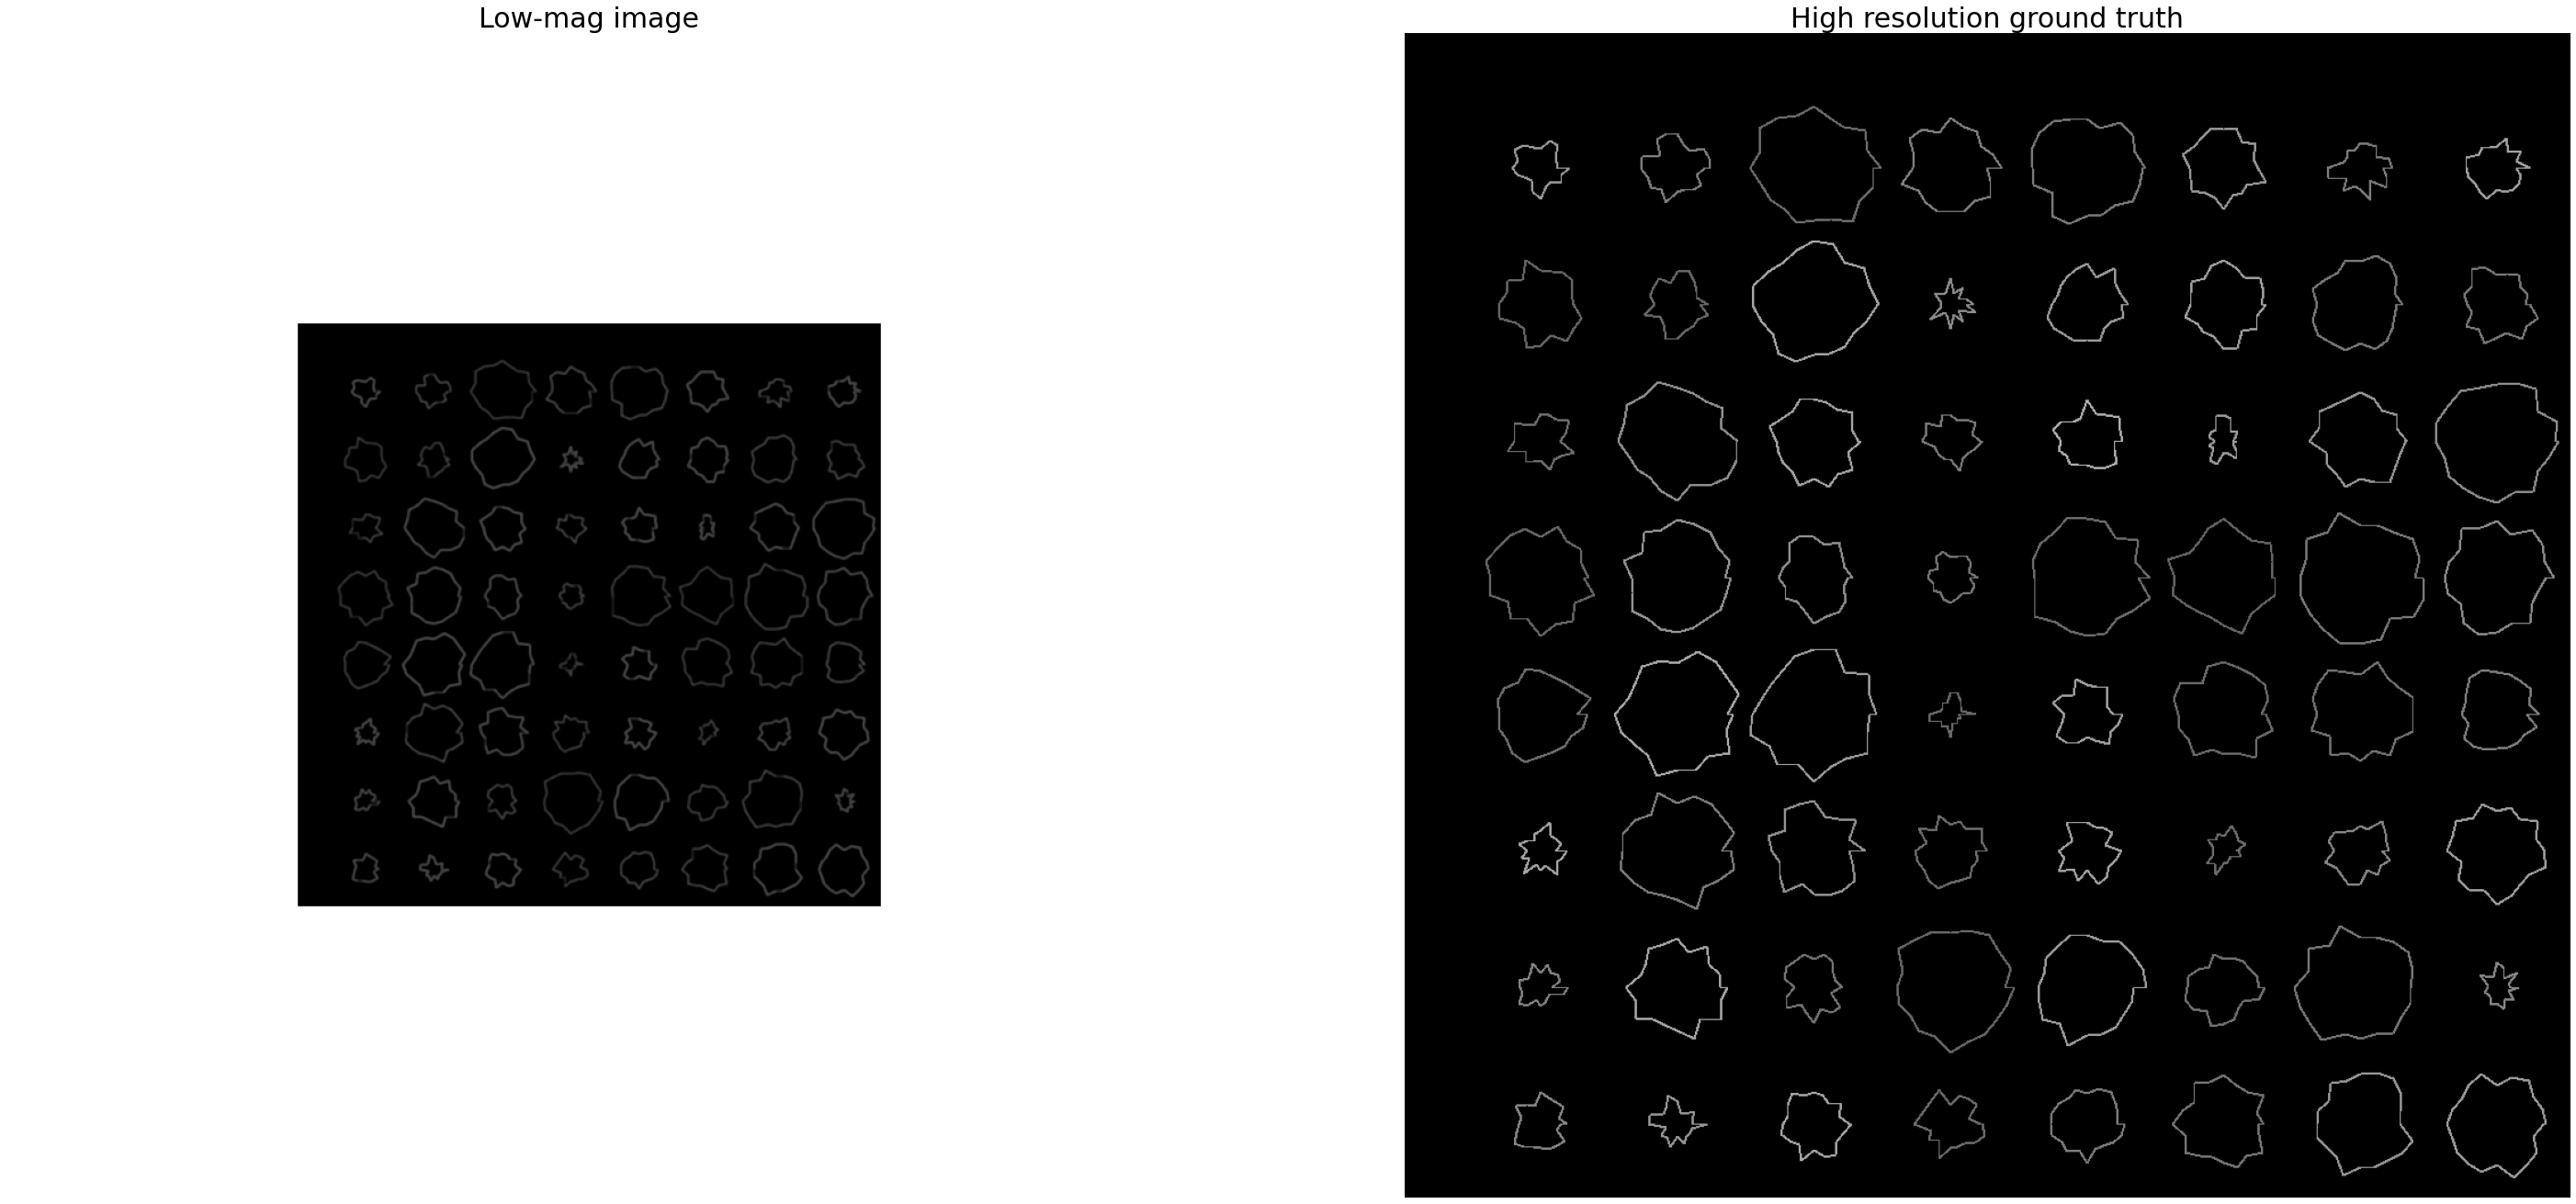

In [111]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(50,25))
im_h = Y[0].permute(1, 2, 0)
im_l = torch.ones(im_h.shape) 
height = im_h.shape[0]
width = im_h.shape[1]
im_l[height//4:height-height//4, width//4:width-width//4, :] = X[0].permute(1,2,0)


axes[0].imshow(im_l)
axes[0].set_title("Low-mag image", fontsize=30);
axes[0].axis('off')
axes[1].imshow(im_h)
axes[1].set_title("High resolution ground truth", fontsize=30);
axes[1].axis('off')


In [0]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


class Net2(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x


In [113]:
import argparse
import torch.optim as optim
from math import log10



torch.manual_seed(12)

device = torch.device("cpu")

print('===> Building model')
model = Net(upscale_factor=2).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.02)


def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(train_loader, 1):
        input_, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        pred = model(input_)
        loss = criterion(pred, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(train_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(train_loader)))


def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in test_loader:
            input_, target = batch[0].to(device), batch[1].to(device)
            prediction = model(input_)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_loader)))


def checkpoint(epoch):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

for epoch in range(1, 20):
    train(epoch)
    test()
    checkpoint(epoch)

===> Building model
===> Epoch[1](1/18): Loss: 0.0118
===> Epoch[1](2/18): Loss: 7.6381
===> Epoch[1](3/18): Loss: 0.0112
===> Epoch[1](4/18): Loss: 0.0102
===> Epoch[1](5/18): Loss: 0.0113
===> Epoch[1](6/18): Loss: 0.0106
===> Epoch[1](7/18): Loss: 0.0099
===> Epoch[1](8/18): Loss: 0.0094
===> Epoch[1](9/18): Loss: 0.0086
===> Epoch[1](10/18): Loss: 0.0103
===> Epoch[1](11/18): Loss: 0.0081
===> Epoch[1](12/18): Loss: 0.0073
===> Epoch[1](13/18): Loss: 0.0075
===> Epoch[1](14/18): Loss: 0.0067
===> Epoch[1](15/18): Loss: 0.0067
===> Epoch[1](16/18): Loss: 0.0069
===> Epoch[1](17/18): Loss: 0.0061
===> Epoch[1](18/18): Loss: 0.0058
===> Epoch 1 Complete: Avg. Loss: 0.4326
===> Avg. PSNR: 22.5613 dB
Checkpoint saved to model_epoch_1.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


===> Epoch[2](1/18): Loss: 0.0056
===> Epoch[2](2/18): Loss: 0.0053
===> Epoch[2](3/18): Loss: 0.0054
===> Epoch[2](4/18): Loss: 0.0052
===> Epoch[2](5/18): Loss: 0.0048
===> Epoch[2](6/18): Loss: 0.0044
===> Epoch[2](7/18): Loss: 0.0044
===> Epoch[2](8/18): Loss: 0.0043
===> Epoch[2](9/18): Loss: 0.0041
===> Epoch[2](10/18): Loss: 0.0039
===> Epoch[2](11/18): Loss: 0.0038
===> Epoch[2](12/18): Loss: 0.0037
===> Epoch[2](13/18): Loss: 0.0038
===> Epoch[2](14/18): Loss: 0.0034
===> Epoch[2](15/18): Loss: 0.0033
===> Epoch[2](16/18): Loss: 0.0034
===> Epoch[2](17/18): Loss: 0.0032
===> Epoch[2](18/18): Loss: 0.0031
===> Epoch 2 Complete: Avg. Loss: 0.0042
===> Avg. PSNR: 25.1956 dB
Checkpoint saved to model_epoch_2.pth
===> Epoch[3](1/18): Loss: 0.0030
===> Epoch[3](2/18): Loss: 0.0029
===> Epoch[3](3/18): Loss: 0.0029
===> Epoch[3](4/18): Loss: 0.0028
===> Epoch[3](5/18): Loss: 0.0027
===> Epoch[3](6/18): Loss: 0.0026
===> Epoch[3](7/18): Loss: 0.0026
===> Epoch[3](8/18): Loss: 0.0027
=

In [0]:
from imageio  import imwrite
import numpy as np 

originals, truths, predictions = [], [], []
i = 0

!rm -rf predictions
os.mkdir("predictions")
with torch.no_grad():
  for batch in test_loader:
    input_, target = batch[0].to(device), batch[1].to(device)
    originals.append(input_)
    pred = model(input_)
    predictions.append(pred)
    truths.append(target)
    for p in pred: 
      im = (255*(p.permute(1,2,0).numpy())).astype(np.uint8)
      imwrite("predictions/" + shape + "_" + number + "_%d.tif" %(i+1), im)
      i += 1


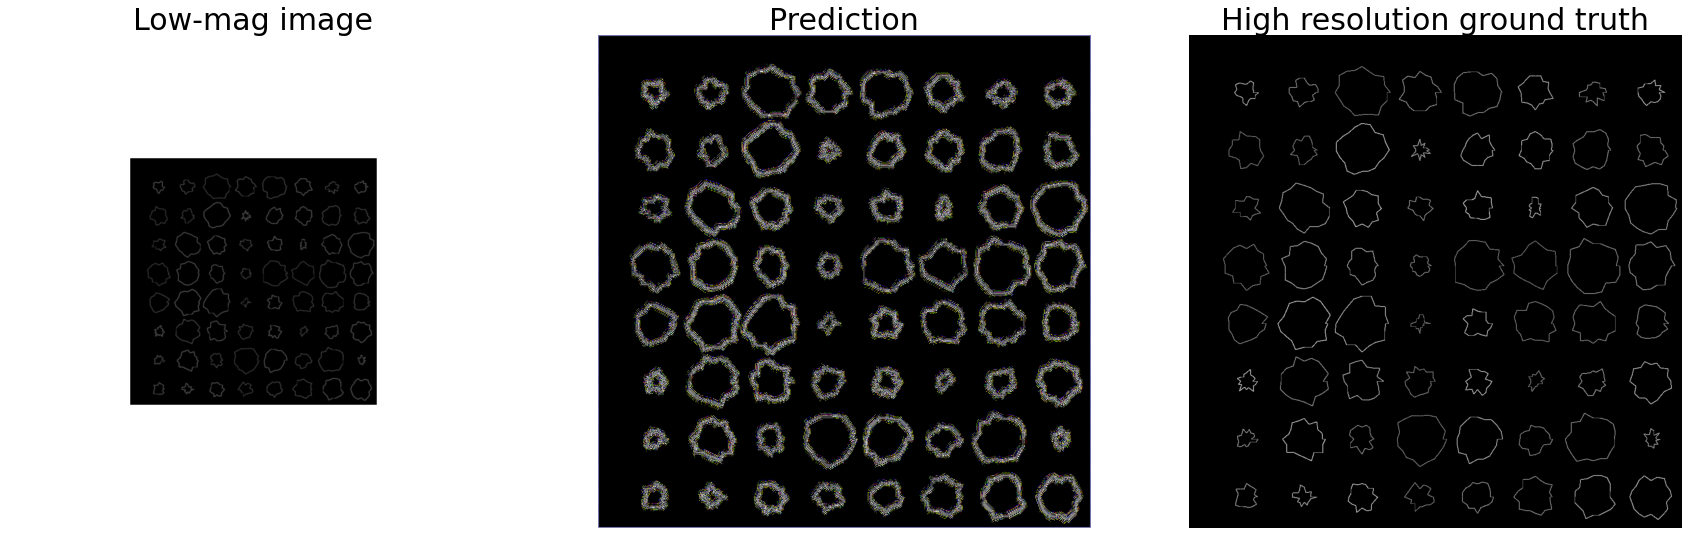

In [119]:
def compare(o,p,t): 
  fig, axes = plt.subplots(1,3, figsize=(30,15))

  op = torch.ones(t.shape)
  height = t.shape[1]
  width = t.shape[1]
  op[:, height//4:height-height//4, width//4:width-width//4] = o

  op = (255*op.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(op)
  axes[0].set_title("Low-mag image", fontsize=30);
  axes[0].axis('off')
  
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(p)
  axes[1].set_title("Prediction", fontsize=30);
  axes[1].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[2].imshow(t)
  axes[2].set_title("High resolution ground truth", fontsize=30);
  axes[2].axis('off')
compare(originals[0][0], predictions[0][0], truths[0][0])

dtype('uint8')

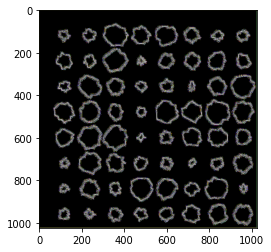

In [121]:
from imageio  import imread
img_read = imread("predictions/" + shape + "_" + number + "_1.tif")
plt.imshow((255*img_read).astype(np.uint8))
img_read.dtype


In [122]:
I = imread("/content/data/16_circle/High/Circle_16_1.tif")
I.dtype

dtype('uint8')

In [123]:
!zip -r /content/file.zip /content/predictions

  adding: content/predictions/ (stored 0%)
  adding: content/predictions/irregular_64_63.tif (deflated 86%)
  adding: content/predictions/irregular_64_62.tif (deflated 87%)
  adding: content/predictions/irregular_64_1.tif (deflated 86%)
  adding: content/predictions/irregular_64_55.tif (deflated 87%)
  adding: content/predictions/irregular_64_25.tif (deflated 87%)
  adding: content/predictions/irregular_64_37.tif (deflated 87%)
  adding: content/predictions/irregular_64_68.tif (deflated 87%)
  adding: content/predictions/irregular_64_53.tif (deflated 88%)
  adding: content/predictions/irregular_64_67.tif (deflated 86%)
  adding: content/predictions/irregular_64_61.tif (deflated 86%)
  adding: content/predictions/irregular_64_51.tif (deflated 86%)
  adding: content/predictions/irregular_64_22.tif (deflated 87%)
  adding: content/predictions/irregular_64_27.tif (deflated 87%)
  adding: content/predictions/irregular_64_57.tif (deflated 87%)
  adding: content/predictions/irregular_64_34.ti

In [0]:
from google.colab import files
files.download("/content/file.zip")